# The Dataset

The dataset is based on a similar dataset that was [published together with other datasets from fundamental physics](https://doi.org/10.1007/s41781-022-00082-6).

Here we want to use a slighty less processed version to learn a bit about the physics content and how we can transform it such that it can be input to a neural network.

It is provided in [Parquet](https://parquet.apache.org) format - written out using the [Awkward Array](https://awkward-array.org) library.

In [1]:
#!pip install "awkward>=2"
# if not installed yet

In [2]:
import awkward as ak
import numpy as np

The dataset contains 4 "row groups" - each of them containing 100k events. Here we load only the first row group (index 0):

In [3]:
from urllib.request import urlretrieve
import os

In [4]:
filename = "smartbkg_dataset_4k.parquet"
url = "https://zenodo.org/records/15303496/files/smartbkg_dataset_4k_training.parquet?download=1"

In [5]:
if not os.path.exists(filename):
    urlretrieve(url, filename)

In [6]:
ak_data = ak.from_parquet(filename, row_groups=[0])

In [7]:
ak_data

<Array [{label: 1, particles: [...]}, ...] type='100000 * {label: uint8, pa...'>

The structure of the data is the following
- `particles`: generator-level quantities for each event - a variable length list of particles to be used as input for the training
    - `pdg`: a number identifying the particle type according to the [numbering scheme of the Particle Data Group (PDG)](https://pdg.lbl.gov/2022/reviews/rpp2022-rev-monte-carlo-numbering.pdf)
    - `index`: an identifier of the particle in a particular event
    - `mother_index`: the `index` of the mother particle - this defines the decay tree
    - the rest are generator-level features of the particles (all in the lab frame)
        - `prodTime`: time of production (e.g. decay of mother particle) in ns
        - `x, y, z`: positions of the production vertex in cm
        - `px, py, pz, energy`: 4-momentum vector components in GeV (natural units with c=1)
- `label`: `1` for events that **pass** the downstream event selection and `0` for those that **fail** it

Here we will use a pandas DataFrame representation:

In [8]:
import pandas as pd

In [9]:
df_particles = ak.to_dataframe(ak_data.particles, levelname=lambda i: {0: "event", 1: "particle"}[i])
df_particles

prodTime     energy         x         y         z        px  \
event particle                                                                
0     0         0.000000  10.996101  0.000699  0.000002 -0.022267  0.456207   
      1         0.000000   5.464126  0.000699  0.000002 -0.022267  0.111765   
      2         0.000000   5.531976  0.000699  0.000002 -0.022267  0.344442   
      3         0.001168   2.266968  0.001415  0.001270 -0.013358  0.580729   
      4         0.001168   2.492515  0.001415  0.001270 -0.013358 -0.305733   
...                  ...        ...       ...       ...       ...       ...   
99999 45        0.037855   0.206991  0.358612 -0.022536 -0.137919 -0.001047   
      46        0.037855   0.291011  0.358614 -0.022536 -0.137922  0.152196   
      47        0.037855   0.039752  0.358614 -0.022536 -0.137922  0.033537   
      48        0.037855   0.146029  0.358612 -0.022540 -0.137907 -0.032881   
      49        0.037855   0.060963  0.358612 -0.022540 -0.137907  0.031834   

                      py        pz     pdg  index  mother_index  
event particle                                                   
0     0        -0.000000  2.993447  300553      0             0  
      1         0.197746  1.389834    -511      1             0  
      2        -0.197746  1.603613     511      2             0  
      3        -0.699431  0.904001     411      3             1  
      4         1.128371  0.896693    -413      4             1  
...                  ...       ...     ...    ...           ...  
99999 45       -0.049284  0.148985     111     68            62  
      46        0.022208 -0.247044      22     69            67  
      47        0.017458  0.012277      22     70            67  
      48        0.002270  0.142260      22     71            68  
      49       -0.051554  0.006725      22     72            68  

[3962271 rows x 11 columns]

In [10]:
labels = ak_data.label.to_numpy()

In [11]:
df_label = pd.DataFrame(labels, columns=["label"])
df_label.index = df_label.index.rename("event")
df_label

,label
event,
0,1
1,1
2,0
3,1
4,1
...,...
99995,0
99996,0
99997,1


In [12]:
df = df_particles.join(df_label)
df

prodTime     energy         x         y         z        px  \
event particle                                                                
0     0         0.000000  10.996101  0.000699  0.000002 -0.022267  0.456207   
      1         0.000000   5.464126  0.000699  0.000002 -0.022267  0.111765   
      2         0.000000   5.531976  0.000699  0.000002 -0.022267  0.344442   
      3         0.001168   2.266968  0.001415  0.001270 -0.013358  0.580729   
      4         0.001168   2.492515  0.001415  0.001270 -0.013358 -0.305733   
...                  ...        ...       ...       ...       ...       ...   
99999 45        0.037855   0.206991  0.358612 -0.022536 -0.137919 -0.001047   
      46        0.037855   0.291011  0.358614 -0.022536 -0.137922  0.152196   
      47        0.037855   0.039752  0.358614 -0.022536 -0.137922  0.033537   
      48        0.037855   0.146029  0.358612 -0.022540 -0.137907 -0.032881   
      49        0.037855   0.060963  0.358612 -0.022540 -0.137907  0.031834   

                      py        pz     pdg  index  mother_index  label  
event particle                                                          
0     0        -0.000000  2.993447  300553      0             0      1  
      1         0.197746  1.389834    -511      1             0      1  
      2        -0.197746  1.603613     511      2             0      1  
      3        -0.699431  0.904001     411      3             1      1  
      4         1.128371  0.896693    -413      4             1      1  
...                  ...       ...     ...    ...           ...    ...  
99999 45       -0.049284  0.148985     111     68            62      1  
      46        0.022208 -0.247044      22     69            67      1  
      47        0.017458  0.012277      22     70            67      1  
      48        0.002270  0.142260      22     71            68      1  
      49       -0.051554  0.006725      22     72            68      1  

[3962271 rows x 12 columns]

First, let's plot the global distribution (across all events) for our particle features:

In [13]:
feature_columns = ["prodTime", "x", "y", "z", "energy", "px", "py", "pz"]

In [14]:
import matplotlib.pyplot as plt

In [15]:
def plot_feats(df, column_names, bins=100, log=True, range_fn=None):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 5))
    for ax, field in zip(axs.ravel(), column_names):
        array = df[field].to_numpy()
        if range_fn is None:
            bin_range = None
        else:
            bin_range = range_fn(array)
        ax.hist(array, bins=bins, range=bin_range)
        if log:
            ax.set_yscale("log")
        ax.set_title(field)
    fig.tight_layout()
    plt.close(fig)
    return fig

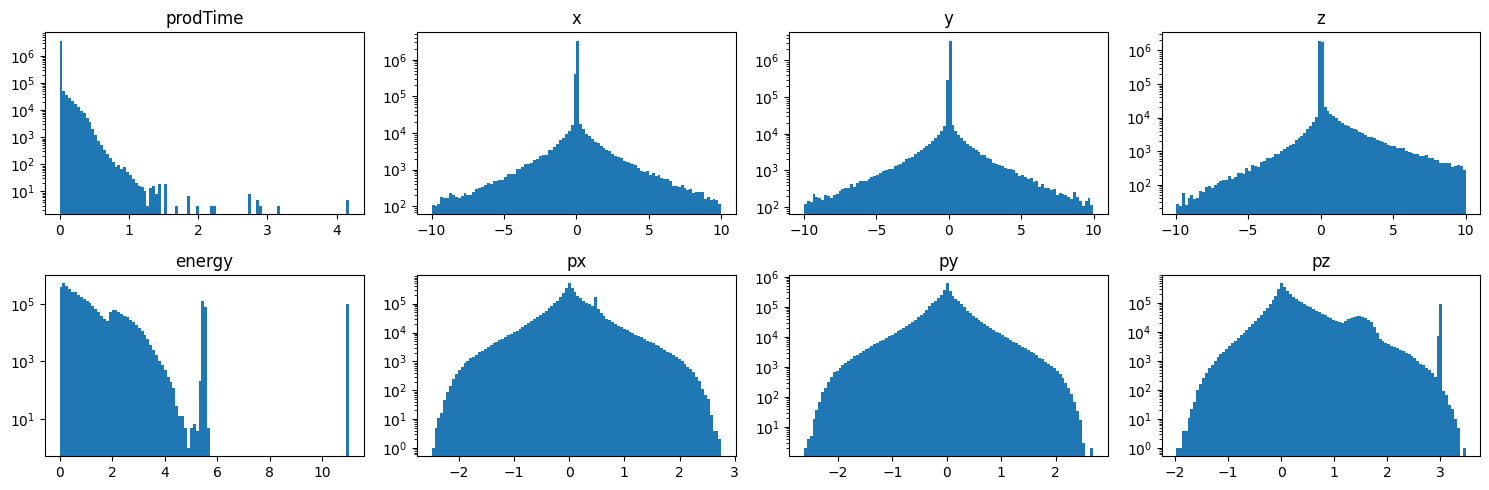

In [16]:
plot_feats(df, feature_columns, log=True) # log scale, full range

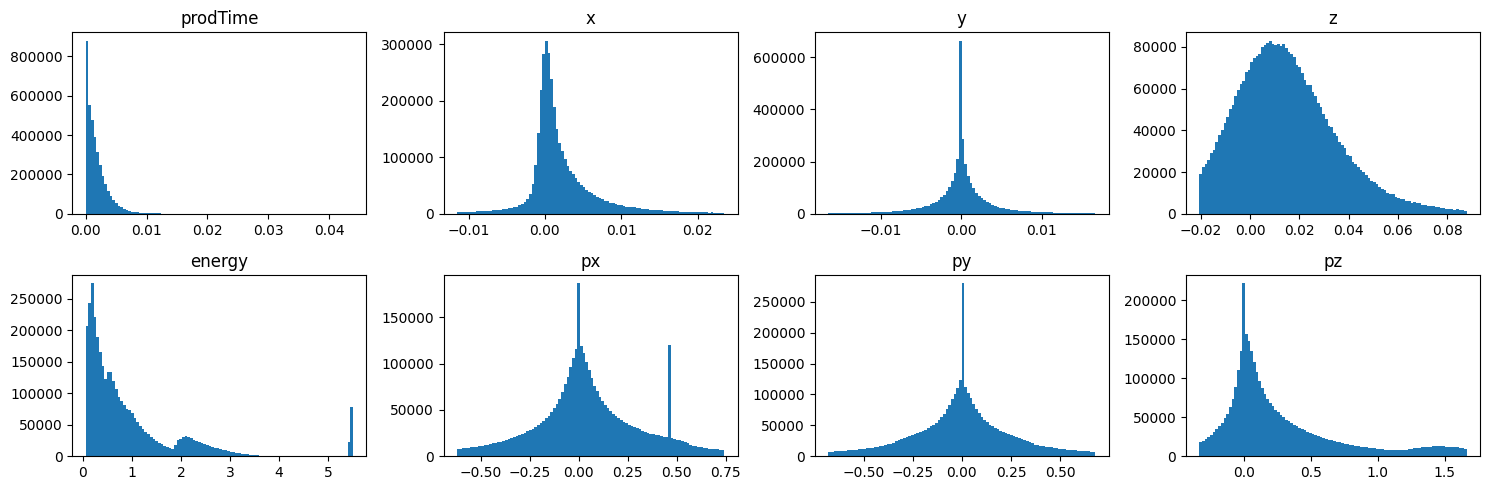

In [17]:
plot_feats(df, feature_columns, log=False, range_fn=lambda x: np.quantile(x, [0.05, 0.95])) # linear scale, 5% - 95% quantiles of distribution

We can see a few characteristics of the experiment that have been taken into account in the simulation:
- A peak in the energy at the total energy of colliding beams (7 GeV + 4 GeV = 11 GeV) - this corresponds to the Y(4S) resonance particles.
- The next-lower peak in the energy is at around half of that - corresponding to the B mesons. The rest are then all the other particles in the decay chains.
- The `z` vertex positions and momenta have a bias towards positive values (and a peak at 7 GeV - 4 GeV = 3 GeV for `pz` for the Y(4S) particles) - due to the asymmetric beam energies
- The peak in `px` at around 0.46 GeV comes from the crossing angle of the beams - resulting in a small boost in x-direction for the Y(4S) particles.

Note: particles with `x`, `y`, `z` values outside of the `[-10, 10]` range are removed for technical reasons.

<div class="alert alert-block alert-success">
    <b>Exercise:</b> Overlay the distribution of features for events with label 0 and 1. Does the global distribution of features alone already provide discriminative power?
<br><br>

Hint: use e.g. `array[df.label==0]` to get the global distribution for label 0 events. To overlay both histograms you can use `histtype="step"` or `alpha=0.5` as arguments to `plt.hist`.
</div>

In [18]:
def plot_feats_overlay(df, column_names, bins=100, log=True, range_fn=None):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 5))
    for ax, field in zip(axs.ravel(), column_names):
        label_0 = df[df.label == 0][field].to_numpy()
        label_1 = df[df.label == 1][field].to_numpy()
        if range_fn is None:
            bin_range = None
        else:
            bin_range = range_fn(label_0)
        ax.hist([label_0,label_1], bins=bins, histtype = "step", range=bin_range, label = ["Label 0", "Label 1"])
        if log:
            ax.set_yscale("log")
        ax.set_title(field)
    fig.tight_layout()
    plt.legend()
    plt.close(fig)
    return fig

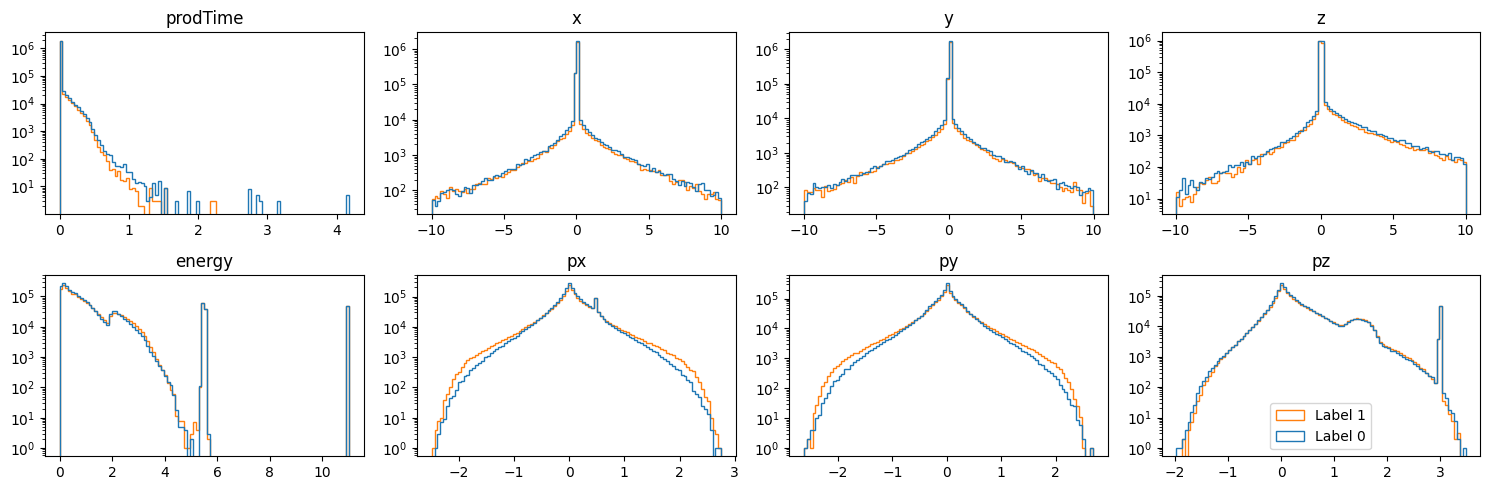

In [19]:
plot_feats_overlay(df, feature_columns, log=True)

We can build decay trees using the `index` and `mother_index` fields. For visualization we use `grahviz` and to convert the PDG ids we use a dictionary to convert into a human readable unicode string:

In [22]:
from pdg_to_unicode import pdg_to_unicode

The first 3 particles of each event are typically the Y(4S) resonance `300553` decaying into a neutral B and anti-B meson:

In [23]:
df.pdg.loc[0][:3]

particle
0    300553
1      -511
2       511
Name: pdg, dtype: int32

In [24]:
pdg_to_unicode[300553], pdg_to_unicode[-511], pdg_to_unicode[511]

('ϒ(4S)', 'B̅⁰', 'B⁰')

In [25]:
import graphviz

In [26]:
def draw_graph(x):
    g = graphviz.Digraph()
    for i, pdg in zip(x["index"], x["pdg"]):
        g.node(str(i), label=pdg_to_unicode[pdg])
    for src, dst in zip(x["mother_index"], x["index"]):
        if src == dst: # particles without mother point to themselves
            continue
        g.edge(str(src), str(dst))
    return g

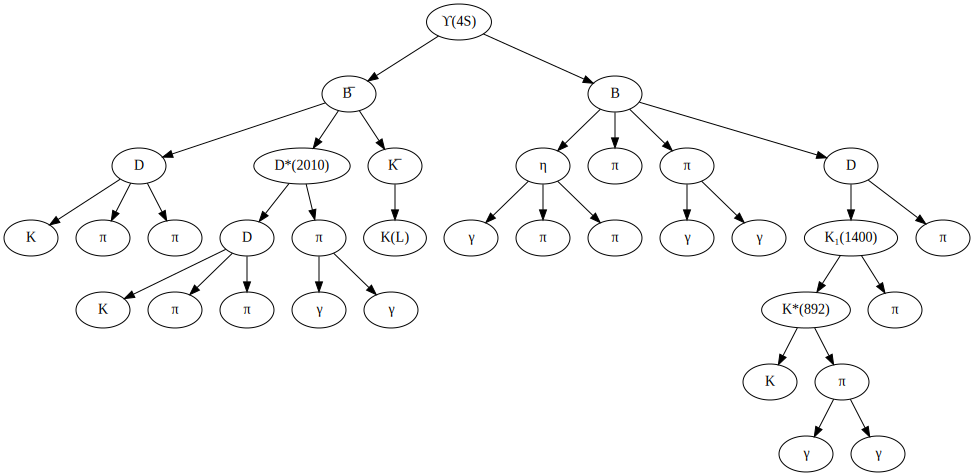

In [27]:
event_id = 0 # change this to look at different events
draw_graph(df.loc[event_id])

So each one of these decay trees (together with the features for each particle) will make up **one instance** of our training dataset.

## Preprocessing

To use the data as input for a neural network we need to do some preprocessing.

### Index the PDG ids
First, we need to find a way to input the pdg ids.

The numerical values are not very useful for processing in neural network layers, so we want to convert the particle identifier into a vector (compare e.g. word embeddings in a language model) - either with [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Machine_learning_and_statistics) or by utilizing an [Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). In any case, we need to index (enumerate) them such that they are numbers in the range of `[0, num_pdg_ids]`

In [28]:
unique_pdg_ids = np.unique(df.pdg.to_numpy())
unique_pdg_ids

array([-9000211,  -100323,   -30343,   -30323,   -20433,   -20413,
         -20323,   -20313,   -20213,   -10433,   -10431,   -10413,
         -10411,   -10323,   -10321,   -10313,   -10311,   -10213,
          -4334,    -4332,    -4324,    -4322,    -4314,    -4312,
          -4232,    -4224,    -4222,    -4214,    -4212,    -4132,
          -4122,    -4114,    -4112,    -3334,    -3324,    -3322,
          -3314,    -3312,    -3224,    -3222,    -3214,    -3212,
          -3124,    -3122,    -3114,    -3112,    -2224,    -2214,
          -2212,    -2114,    -2112,    -1114,     -511,     -433,
           -431,     -423,     -421,     -415,     -413,     -411,
           -325,     -323,     -321,     -315,     -313,     -311,
           -215,     -213,     -211,      -44,      -16,      -15,
            -14,      -13,      -12,      -11,       11,       12,
             13,       14,       15,       16,       22,       44,
            111,      113,      115,      130,      211,      

In [29]:
num_pdg_ids = len(unique_pdg_ids)

In [30]:
num_pdg_ids

181

We will use the following dictionary to map the pdg ids. We will start counting at 1 since 0 will be a special padding value (more later)

The value `num_pdg_ids + 1` will be reserved as a fallback token in case we encounter unseen pdg ids in the test data.

In [31]:
mapping = dict(zip(unique_pdg_ids.tolist(), range(1, num_pdg_ids + 1)))

for (key, value), _ in zip(mapping.items(), range(10)):
    print(f"{key}: {value}")
print("...")

-9000211: 1
-100323: 2
-30343: 3
-30323: 4
-20433: 5
-20413: 6
-20323: 7
-20313: 8
-20213: 9
-10433: 10
...


In [32]:
def map_np(array, mapping, fallback=None):
    """
    Apply a mapping over a numpy array - along the lines of
    https://stackoverflow.com/a/16993364
    """
    if fallback is None:
        fallback = max(mapping.values()) + 1
    # inv is the original array with the values replaced by their indices in the unique array
    unique, inv = np.unique(array, return_inverse=True)
    np_mapping = np.array([mapping.get(x, fallback) for x in unique])
    return np_mapping[inv]

In [33]:
# Example:
map_np(np.array([42, 753, 42, 1111, 753, 86277, 27786]), {42: 1, 753: 2, 1111: 3}, fallback=4)

array([1, 2, 1, 3, 2, 4, 4])

To have a consistent mapping for all datasets we will use the mapping defined in `pdg_mapping.json` which was produced by the script `create_pdg_mapping.py` that ran on all 4 row groups of the training data.

In [34]:
import json

In [35]:
with open("pdg_mapping.json") as f:
    pdg_mapping = dict(json.load(f))

In [36]:
# adds another array with the mapped particle ids to the DataFrame
df["pdg_mapped"] = map_np(df.pdg, pdg_mapping, fallback=len(pdg_mapping) + 1)

In [37]:
df.pdg

event  particle
0      0           300553
       1             -511
       2              511
       3              411
       4             -413
                    ...  
99999  45             111
       46              22
       47              22
       48              22
       49              22
Name: pdg, Length: 3962271, dtype: int32

In [38]:
df.pdg_mapped

event  particle
0      0           180
       1            54
       2           116
       3           106
       4            60
                  ... 
99999  45           86
       46           84
       47           84
       48           84
       49           84
Name: pdg_mapped, Length: 3962271, dtype: int64

### List of arrays representation

For loading the data into ML models it is useful to also have a representation of the data as a list of numpy arrays. We will have one list for each `pdg_mapped`, `index` and `mother_index` as well as one list of 2D numpy arrays for the particle features.

To create this we will proceed as follows:
* create "flat" numpy arrays (single array across event boundaries)
* use a `pd.DataFrame.groupby` operation to get the indices of groups of particles
* use these indices to create numpy arrays for each event

In [39]:
flat = {
    "features": df[feature_columns].to_numpy(),
    "pdg_mapped": df["pdg_mapped"].to_numpy(),
    "index": df["index"].to_numpy(),
    "mother": df["mother_index"].to_numpy(),
}

In [40]:
gb_indices = df.groupby("event").indices

e.g. the following will give the indices of the first event:

In [41]:
gb_indices[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

Now we can fill the list of arrays:

In [42]:
data = {}
for idx in gb_indices.values():
    for k, array in flat.items():
        data.setdefault(k, [])
        data[k].append(array[idx])

In [43]:
data["features"][0].shape

(34, 8)

In [44]:
data["pdg_mapped"][0].shape

(34,)

# A simple "Deep Set" Model

As a starting point we will view our data as an **unordered set** of particles. The *Deep Set* model we will use applies a per **per-item transformation** ($\phi$) followed by a **permutation invariant aggregation**, typically taking the sum/mean or min/max whose output can then be transformed ($\rho$) by any means, e.g. another MLP.

![](figures/deep_set_transformation.png)

See [arXiv:1703.06114](https://arxiv.org/abs/1703.06114) for a detailed discussion.

The per-item transformation we can do easily do in `torch` by using a `Linear` layer - when operating on a sequence/set it will be applied per item:

In [45]:
import torch
from torch import nn

In [46]:
per_item_layer = nn.Linear(in_features=3, out_features=4)

Let's create some example inputs to see what happens to them when they are passed through the layers:

In [47]:
inputs = torch.rand(2, 5, 3)
inputs

tensor([[[0.9696, 0.0352, 0.6745],
         [0.5935, 0.1850, 0.8894],
         [0.5210, 0.8168, 0.3807],
         [0.4372, 0.3213, 0.3537],
         [0.3448, 0.2315, 0.3111]],

        [[0.5908, 0.3512, 0.5395],
         [0.4815, 0.2379, 0.9051],
         [0.1689, 0.4038, 0.3009],
         [0.8570, 0.8979, 0.0115],
         [0.6605, 0.7200, 0.0153]]])

In [48]:
per_item_layer(inputs)

tensor([[[-0.4004,  0.5795,  0.1564, -0.3841],
         [-0.2647,  0.3911,  0.2960, -0.3007],
         [-0.0283,  0.5311,  0.1335, -0.6900],
         [-0.2893,  0.4427,  0.2659, -0.4602],
         [-0.3405,  0.4005,  0.3153, -0.4092]],

        [[-0.2446,  0.4770,  0.2218, -0.4631],
         [-0.2292,  0.3453,  0.3302, -0.2920],
         [-0.2448,  0.3456,  0.3465, -0.4434],
         [-0.0709,  0.7586, -0.0565, -0.9041],
         [-0.1550,  0.6517,  0.0571, -0.7769]]], grad_fn=<ViewBackward0>)

For aggregation we just take the mean:

In [49]:
inputs.mean(axis=1)

tensor([[0.5732, 0.3180, 0.5219],
        [0.5517, 0.5222, 0.3545]])

A possible model (operating only on particle features) would be:

In [50]:
class DeepSet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.per_item_mlp = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
        )
        self.global_mlp = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        
    def forward(self, inputs):
        x = inputs
        x = self.per_item_mlp(x)
        x = x.mean(axis=-2)
        x = self.global_mlp(x)
        return x

model = DeepSet(len(feature_columns))
model

DeepSet(
  (per_item_mlp): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
  )
  (global_mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

The model can take arbitrary sized batches with an arbitrary sized set of features:

So this maps a set of particle features into a single number:

In [51]:
inputs = torch.tensor(data["features"][0][np.newaxis, :])
inputs.shape

torch.Size([1, 34, 8])

In [52]:
model(inputs)

tensor([[-0.0305]], grad_fn=<AddmmBackward0>)

But what if not all sets in a batch of events have the same size?

## 0-Padding

Many standard operations in NN frameworks like PyTorch work only on arrays with same length lists for each subentry (there are also implementations for sparse computations for neural networks, but we won't consider these here). So we need to have **sequences of the same length, within one batch of data**.

To achieve this we will **fill the values with 0** for instances in a batch with a lower number of particles

We can pad the sequences with the following helper function (similar to [`torch.nn.utils.rnn.pad_sequence`](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html), but using numpy). To do this, we first create a matrix of zeros with the appropriate shape and data type. Then we replace the leftmost zeros row by row with the existing sequences. Due to the way numpy arrays work, this is much more efficient than concatenating each sequence with arrays of zeros and stacking them.

In [53]:
def pad_sequences(sequences, maxlen=None):
    if maxlen is None:
        maxlen = max(len(array) for array in sequences)
    if sequences[0].ndim == 2:
        shape = (len(sequences), maxlen, sequences[0].shape[-1])
    else:
        shape = (len(sequences), maxlen)
    batch = np.zeros(shape, dtype=sequences[0].dtype)
    for i, array in enumerate(sequences):
        batch[i, :len(array)] = array
    return batch

In [54]:
pad_sequences(data["pdg_mapped"][:5]).shape

(5, 40)

In [55]:
pad_sequences(data["pdg_mapped"][:5], maxlen=100).shape

(5, 100)

In [56]:
pad_sequences(data["pdg_mapped"][:5])

array([[180,  54, 116, 106,  60,  67,  93,  90,  86,  61,  64,  90,  90,
         61,  86,  89,  84,  70,  90,  84,  84, 166,  70, 100,  70,  70,
         84,  84, 101,  70, 100,  86,  84,  84,   0,   0,   0,   0,   0,
          0],
       [180,  54, 116,  86,  94, 109, 111,  58,  70,  84,  84,  70,  90,
         64,  90,  86,  90,  70,  90, 100,  70,  86,  84,  84,  84,  84,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [180, 116,  54,  60,  73,  83, 106,  70,  87,  87,  58,  70,  75,
         81,  72, 101,  96,  90,  70,  84,  90,  70,  84, 100,  64,  90,
         70,  86, 100,  86,  86,  86,  84,  84,  84,  84,  84,  84,  84,
         84],
       [180, 116,  54,  61,  90, 106,  70,  93,  94,  87, 100,  70,  70,
         66,  77,  79,  86,  86,  86,  70,  90,  86,  90,  70,  67,  86,
         84,  84,  84,  84,  84,  84,  84,  84,  96,  84,  84,  90,  70,
          0],
       [180, 116,  54,  60,  90,  93, 106,  69,  87,  58,  70,  70, 

In [57]:
pad_sequences(data["features"][:5]).shape

(5, 40, 8)

In [58]:
pad_sequences(data["features"][:5])

array([[[ 0.00000000e+00,  6.98652759e-04,  2.18134778e-06, ...,
          4.56207246e-01, -0.00000000e+00,  2.99344707e+00],
        [ 0.00000000e+00,  6.98652759e-04,  2.18134778e-06, ...,
          1.11764818e-01,  1.97746336e-01,  1.38983357e+00],
        [ 0.00000000e+00,  6.98652759e-04,  2.18134778e-06, ...,
          3.44442427e-01, -1.97746336e-01,  1.60361338e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00, -1.08639465e-03,  4.78833226e-06, ...,
          4.56533760e-01, -0.00000000e+00,  2.99640870e+00],
        [ 0.00000000e+00, -1.08639465e-03,  4.78833226e-06, ...,
          4.18623686e-01,  2.54650414e

## Masking

A typical convention to treat values that are supposed to be ignored is to propagate a mask array through. In pytorch the convention is usually that values that are supposed to be ignored have a `True` in the mask and those that are not supposed to be ignored a `False`.

In [59]:
test_batch = np.zeros((2, 5, 4))
test_batch[0, :3] = np.random.rand(3, 4)
test_batch[1, :4] = np.random.rand(4, 4)
test_batch = torch.tensor(test_batch)

In [60]:
test_batch

tensor([[[0.0050, 0.7225, 0.1931, 0.4379],
         [0.2947, 0.7468, 0.4452, 0.2834],
         [0.3424, 0.4539, 0.2269, 0.3447],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.8165, 0.2167, 0.6685, 0.2033],
         [0.0883, 0.9328, 0.0322, 0.7403],
         [0.7146, 0.1151, 0.1873, 0.2908],
         [0.4084, 0.6511, 0.7626, 0.9998],
         [0.0000, 0.0000, 0.0000, 0.0000]]], dtype=torch.float64)

In [61]:
mask = (test_batch == 0).all(axis=-1)

In [62]:
mask

tensor([[False, False, False,  True,  True],
        [False, False, False, False,  True]])

The mask can be inverted using `~`

In [63]:
~mask

tensor([[ True,  True,  True, False, False],
        [ True,  True,  True,  True, False]])

We can compute a masked average by setting the masked values to 0 and then taking first the sum, followed by dividing my the sum of the inverse mask.

In [64]:
def masked_average(batch, mask):
    batch = batch.masked_fill(mask[..., np.newaxis], 0)
    sizes = (~mask).sum(axis=1, keepdim=True)
    return batch.sum(axis=1) / sizes

Breaking this down step by step:

* `batch.masked_fill(mask[..., np.newaxis], 0)` fill masked values with 0s
* `[..., np.newaxis]` adds another dimension to ensure the same number of dimensions as the batch
* `~mask` invert the mask
* `(~mask).sum(axis=1, keepdim=True)` summing over not-masked values produces the sizes for each batch element. The argument `keepdim=True` ensures to keep the same number of dimensions as the batch.
* `batch.sum(axis=1) / sizes` produces the average

In [65]:
masked_average(test_batch, mask)

tensor([[0.2140, 0.6411, 0.2884, 0.3553],
        [0.5070, 0.4789, 0.4126, 0.5586]], dtype=torch.float64)

In [66]:
test_batch.sum(axis=1) / torch.tensor([[3], [4]]) # works in this case since masked values are already 0

tensor([[0.2140, 0.6411, 0.2884, 0.3553],
        [0.5070, 0.4789, 0.4126, 0.5586]], dtype=torch.float64)

In [67]:
test_batch.mean(axis=1) # not the same, since it averages over all 5 elements!

tensor([[0.1284, 0.3846, 0.1730, 0.2132],
        [0.4056, 0.3831, 0.3301, 0.4468]], dtype=torch.float64)

## Fit the model

Putting everything together we can build a model as follows:
- mask 0-padded entries
- apply a the per-item transformation as a single `Linear` layer
- calculate the mean across the sequence of particles
- apply a number of global `Linear` layers on the averaged features
- output a single number representing the probability of our `y` labels

In [68]:
class DeepSet(nn.Module):
    def __init__(self, num_features=8, units=32):
        super().__init__()
        self.per_item_mlp = nn.Sequential(
            nn.Linear(num_features, units),
            nn.ReLU(),
        )
        self.global_mlp = nn.Sequential(
            nn.Linear(units, units),
            nn.ReLU(),
            nn.Linear(units, 1)
        )
        
    def forward(self, inputs, mask=None):
        x = inputs
        x = self.per_item_mlp(x)
        if mask is not None:
            x = masked_average(x, mask)
        else:
            x = x.mean(axis=-2)
        x = self.global_mlp(x)
        return x
    
model = DeepSet()
model

DeepSet(
  (per_item_mlp): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
  )
  (global_mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

We now fit the model using a random 10% fraction of the dataset for validation during training:

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
x_train, x_val, y_train, y_val = train_test_split(data["features"], labels, test_size=0.1, shuffle=True)

We will create a `Dataset` that inherits from `torch.utils.data.Dataset` that will provide `x` (input) and `y` (target) pairs:

In [71]:
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [72]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [73]:
ds_train = Dataset(x_train, y_train)
ds_val = Dataset(x_val, y_val)

In [74]:
x, y = ds_train[0]
x.shape

(54, 8)

In [75]:
y

np.uint8(0)

We will then use a `DataLoader` to put these instances into batches. We have to provide a function that applies the `pad_sequences` to our input features and calculates the mask then as the `collate_fn` argument to our `DataLoader`:

In [76]:
def collate_fn(inputs):
    x = [i[0] for i in inputs]
    y = [i[1] for i in inputs]
    x = torch.tensor(pad_sequences(x))
    y = torch.tensor(y)
    mask = (x == 0).all(axis=-1)
    return x, y, mask

In [77]:
for batch in DataLoader(ds_train, batch_size=256, collate_fn=collate_fn, shuffle=True):
    pass

In [78]:
batch

(tensor([[[ 0.0000e+00,  7.6637e-05,  1.6116e-06,  ...,  4.5674e-01,
           -0.0000e+00,  3.0068e+00],
          [ 0.0000e+00,  7.6637e-05,  1.6116e-06,  ...,  2.2652e-01,
            3.3514e-01,  1.5259e+00],
          [ 0.0000e+00,  7.6637e-05,  1.6116e-06,  ...,  2.3021e-01,
           -3.3514e-01,  1.4810e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 0.0000e+00,  2.9780e-04, -2.5832e-06,  ...,  4.5695e-01,
           -0.0000e+00,  2.9989e+00],
          [ 0.0000e+00,  2.9780e-04, -2.5832e-06,  ...,  8.0473e-02,
           -1.0755e-01,  1.8568e+00],
          [ 0.0000e+00,  2.9780e-04, -2.5832e-06,  ...,  3.7648e-01,
            1.0755e-01,  1.1420e+00],
          ...,
    

Now we can implement the training loop:

For the loss we will use the binary cross entropy - `with_logits` means we use outputs without a sigmoid activation function applied.

The activation function is applied in the loss function instead, allowing a more numerically stable computation:

In [79]:
def loss_fn(logits, y):
    return F.binary_cross_entropy_with_logits(logits.squeeze(), y.float())

We also want to track the accuracy - the fraction of correctly labelled events taking the most likely label

In [80]:
def accuracy_fn(logits, y):
    return (logits.squeeze().sigmoid().round() == y).float().mean()

Now we implement the training loop. We use the adam optimizer with default parameters for now:

In [81]:
def fit(model, dl_train, dl_val, epochs=10, device="cpu", history=None):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())

    def train_step(x, y, mask):
        model.train()
        optimizer.zero_grad()
        logits = model(x, mask=mask)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        return logits.detach().cpu(), loss.detach().cpu()

    def test_step(x, y, mask):
        model.eval()
        with torch.no_grad():
            logits = model(x, mask=mask)
            return logits.cpu(), loss_fn(logits, y.to(device)).cpu()

    def to_device(x, y, mask):
        if isinstance(x, dict):
            x = {k: v.to(device) for k, v in x.items()}
        else:
            x = x.to(device)
        y = y.to(device)
        mask = mask.to(device)
        return x, y , mask

    if history is None:
        history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        for i, (x, y, mask) in enumerate(dl_train):
            x, y, mask = to_device(x, y, mask)
            logits, loss = train_step(x, y, mask)
            train_loss.append(float(loss))
            train_acc.append(float(accuracy_fn(logits, y)))
            print(
                f"Batch {i:03d}/{len(dl_train)}, "
                f"Train loss: {np.mean(train_loss):.3f}, "
                f"Train accuracy: {np.mean(train_acc):.3f}",
                end="\r" if i != len(dl_train) - 1 else ", ",
                flush=True,
            )
        for x, y, mask in dl_val:
            x, y, mask = to_device(x, y, mask)
            logits, loss = test_step(x, y, mask)
            val_loss.append(float(loss))
            val_acc.append(float(accuracy_fn(logits, y)))
        print(
            f"Validation loss: {np.mean(val_loss):.3f}, "
            f"Validation accuracy: {np.mean(val_acc):.3f}"
        )
        history.append(
            {
                "loss": np.mean(train_loss),
                "val_loss": np.mean(val_loss),
                "acc": np.mean(train_acc),
                "val_acc": np.mean(val_acc),
            }
        )
    return history

In [82]:
history = []

dl_opts = dict(batch_size=256, collate_fn=collate_fn)
dl_train = DataLoader(ds_train, shuffle=True, **dl_opts)
dl_val = DataLoader(ds_val, **dl_opts)

In [83]:
history = fit(model, dl_train, dl_val, history=history)

Epoch 0
Batch 351/352, Train loss: 0.684, Train accuracy: 0.564, Validation loss: 0.672, Validation accuracy: 0.589
Epoch 1
Batch 351/352, Train loss: 0.667, Train accuracy: 0.591, Validation loss: 0.661, Validation accuracy: 0.602
Epoch 2
Batch 351/352, Train loss: 0.658, Train accuracy: 0.605, Validation loss: 0.652, Validation accuracy: 0.613
Epoch 3
Batch 351/352, Train loss: 0.651, Train accuracy: 0.614, Validation loss: 0.647, Validation accuracy: 0.619
Epoch 4
Batch 351/352, Train loss: 0.646, Train accuracy: 0.620, Validation loss: 0.643, Validation accuracy: 0.627
Epoch 5
Batch 351/352, Train loss: 0.643, Train accuracy: 0.624, Validation loss: 0.643, Validation accuracy: 0.625
Epoch 6
Batch 351/352, Train loss: 0.641, Train accuracy: 0.627, Validation loss: 0.639, Validation accuracy: 0.627
Epoch 7
Batch 351/352, Train loss: 0.639, Train accuracy: 0.629, Validation loss: 0.639, Validation accuracy: 0.630
Epoch 8
Batch 351/352, Train loss: 0.638, Train accuracy: 0.630, Validat

In [84]:
import pandas as pd

<Axes: >

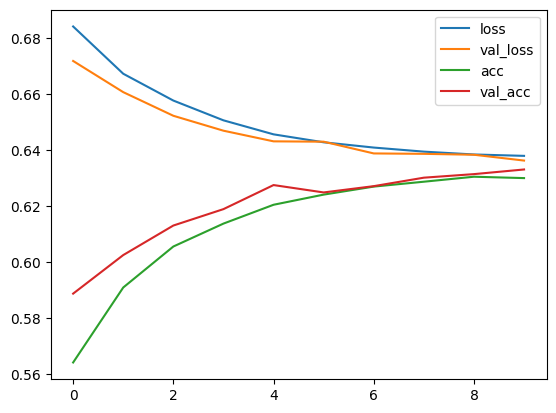

In [85]:
pd.DataFrame(history).plot()

# Embedding layers and multiple inputs

So far we have not used the `pdg` field - the particle type information. One way to use such categorical features is to feed them through an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer.

Since we have mapped the PDG ids to numbers in a continuous range we can directly use such a layer - remember that we shifted the numbers by 1 to be able to use 0 as a padding value. The number of output dimensions is a hyperparameter of this layer:

In [86]:
embed_dim = 8
embedding = nn.Embedding(num_pdg_ids + 1, embed_dim)

All this layer does is to have a learnable matrix of size `(num_categories, embed_dim)` that maps each category to a vector of fixed size:

In [87]:
embedding(torch.tensor(1))

tensor([-0.5513, -0.9638,  1.4180,  0.5373,  0.0193, -0.6377, -0.1062, -0.5633],
       grad_fn=<EmbeddingBackward0>)

In [88]:
embedding(torch.tensor(2))

tensor([2.1596, 1.7312, 0.2451, 1.0189, 1.3705, 1.1484, 0.9866, 0.7467],
       grad_fn=<EmbeddingBackward0>)

It essentially just picks the row with the specified index:

In [89]:
embedding.weight.shape

torch.Size([182, 8])

In [90]:
embedding.weight[1] == embedding(torch.tensor(1))

tensor([True, True, True, True, True, True, True, True])

In [91]:
embedding.weight[2] == embedding(torch.tensor(2))

tensor([True, True, True, True, True, True, True, True])

This is equivalent to applying a Dense layer to one-hot encoded categorical features.

To use both PDG ids and the rest of the particle features as inputs you can create a model that takes multiple inputs and then concatenate the embedded PDG ids with the other features, e.g.

In [92]:
class CombinedModel(nn.Module):
    def __init__(self, num_feat=8, embed_dim=8, num_pdg_ids=num_pdg_ids, units=32):
        super().__init__()
        self.embedding = nn.Embedding(num_pdg_ids + 1, embed_dim)
        self.deep_set = DeepSet(num_features=num_feat + embed_dim, units=units)

    def forward(self, inputs, mask=None):
        pdg = inputs["pdg"]
        feat = inputs["feat"]
        emb = self.embedding(pdg)
        x = torch.cat([feat, emb], -1)
        return self.deep_set(x, mask=mask)

In [93]:
combined_model = CombinedModel()
combined_model

CombinedModel(
  (embedding): Embedding(182, 8)
  (deep_set): DeepSet(
    (per_item_mlp): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): ReLU()
    )
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [94]:
torch.tensor(data["features"][0]).shape

torch.Size([34, 8])

In [95]:
torch.tensor(data["features"][0]).unsqueeze(0).shape # alternative to [np.newaxis, :]

torch.Size([1, 34, 8])

In [96]:
inputs = dict(
    pdg=torch.tensor(data["pdg_mapped"][0]).unsqueeze(0),
    feat=torch.tensor(data["features"][0]).unsqueeze(0)
)

In [97]:
combined_model(inputs)

tensor([[-0.0711]], grad_fn=<AddmmBackward0>)

Note: When fitting such a model you need to adjust the `Dataset` and the `collate_fn` to provide the inputs as a dictionary with fields `"pdg"` and `"feat"`

# Graph Network

Another thing we haven't used yet is the graph structure of the events (the particles form a decay tree). One way to incorporate this is via Graph Convolutions.

## Graph Convolutions

Similar to convolutional networks where we update the state of each pixel by aggregating over neigboring pixels we can perform a *graph convolution* by aggregating over neighboring nodes in a graph:

![cnn vs gcn](figures/cnn_vs_gcn.jpg)

(figure from https://zhuanlan.zhihu.com/p/51990489)

In the "Deep sets" language such a graph convolution corresponds to a *permutation equivariant* tranformation of the set of nodes, since it also does not depend on the ordering if the aggregation is done in a permutation invariant way (e.g. sum/mean/min/max).

A rather simple implementation is given by the update rule introduced in [arXiv:1609.02907](https://arxiv.org/abs/1609.02907) ("GCN")

$ H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)}) $

where $A$ is the *adjacency matrix*, $D$ the *degree matrix*,  $H^{(l)}$ the hidden state of layer $l$ and $W^{(l)}$ the weight matrix of the layer $l$. The tilde above $A$ and $D$ indicates that self-loops were added (all nodes are neighbors of themselves).

An equivalent formulation is

$ h_i^{(l+1)} = \sigma\left(\sum\limits_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h^{(l)}_j W^{(l)}\right) $

where $ \mathcal{N(i)} $ is the set of neighbors of node $i$ and $c_{ij} = \sqrt{N_i}\sqrt{N_j}$ with $N_i$ being the number of neigbors of node $i$

<div class="alert alert-block alert-success">
    <b>Exercise:</b> Verify for one example event that the matrix multiplication of the adjacency matrix with the feature matrix is equivalent to taking the sum over neighbor features for each node. In other words that
    
$ (AF)_{ij} = \sum\limits_{k\in\mathcal{N}(i)}F_{kj} $
</div>

e.g with

In [98]:
F = np.array([[1, 2], [3, 4], [5, 6]])
F # 3 nodes, 2 features each

array([[1, 2],
       [3, 4],
       [5, 6]])

In [99]:
A = np.array([[1, 1, 0], [1, 1, 1], [0, 1, 1]])
A # all nodes are neighbors to themselves, node1 is neighbor of node2 and vice versa, node2 is neighbor of node3 and vice versa

array([[1, 1, 0],
       [1, 1, 1],
       [0, 1, 1]])

In [100]:
# Matrix product AF
AF = A @ F

# Manual neighbor summation: each row i in AF is sum of F[k] over neighbors k of node i
manual = np.zeros_like(F)
for i in range(A.shape[0]):
    neighbors = np.where(A[i] == 1)[0]
    manual[i] = F[neighbors].sum(axis=0)

print("manual: ", manual)
print("AF: ", AF)

manual:  [[ 4  6]
 [ 9 12]
 [ 8 10]]
AF:  [[ 4  6]
 [ 9 12]
 [ 8 10]]


We can decompose the GCN into an operation that normalizes the adjacency matrix via the node degrees:

In [101]:
def normalize_adjacency(adj):
    deg_diag = adj.sum(axis=2)
    deg12_diag = torch.where(deg_diag != 0, deg_diag**-0.5, 0)
    # normalization coefficients are outer product of inverse square root of degree vector
    # gives coeffs_ij = 1 / sqrt(N_i) / sqrt(N_j)
    coeffs = deg12_diag[:, :, np.newaxis] @ deg12_diag[:, np.newaxis, :]
    return adj.float() * coeffs

In [102]:
normalize_adjacency(torch.tensor(A)[np.newaxis, :])

tensor([[[0.5000, 0.4082, 0.0000],
         [0.4082, 0.3333, 0.4082],
         [0.0000, 0.4082, 0.5000]]])

and the update rule that takes the node inputs and the adjacency matrix as parameters:

In [103]:
class GCN(nn.Module):
    """
    Simple graph convolution. Equivalent to GCN from Kipf & Welling (https://arxiv.org/abs/1609.02907)
    when fed a normalized adjacency matrix.
    """
    def __init__(self, in_features, units):
        super().__init__()
        self.linear = nn.Linear(in_features, units)

    def forward(self, inputs, adjacency):
        return adjacency @ self.linear(inputs)

## Adjacency matrix

To get the adjacency matrices in our dataset we create need to create a matrix where the `index` is equal to the `mother` field, e.g. for

In [104]:
index = np.array([1, 2, 3])
mother = np.array([1, 1, 2])

we do 

In [105]:
index[:, np.newaxis] == mother[np.newaxis, :]

array([[ True,  True, False],
       [False, False,  True],
       [False, False, False]])

we used slicing with `np.newaxis` to add extra dimensions to the array, so we made a comparison between a column vector and a row vector which numpy automatically broadcasts

In [106]:
index[:, np.newaxis], mother[np.newaxis, :]

(array([[1],
        [2],
        [3]]),
 array([[1, 1, 2]]))

We will now create adjacency matrices for all events:

In [107]:
def get_adj(index, mother):
    return (
        (mother[np.newaxis, :] == index[:, np.newaxis]) # mother-daughter relations
        | (index[np.newaxis, :] == mother[:, np.newaxis]) # daughter-mother relations
        | (index[np.newaxis, :] == index[:, np.newaxis]) # self loops
    )

In [108]:
data["adj"] = [get_adj(index, mother) for index, mother in zip(data["index"], data["mother"])]

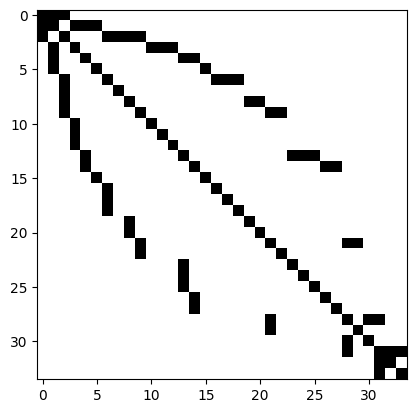

In [109]:
plt.imshow(data["adj"][0], cmap="Greys")

This translates in the same graphs we have seen before, but now we have both mother-daughter and daughter-mother connections and also a connection from each node to itself:

In [110]:
def draw_graph_from_adjacency(adj, pdg):
    g = graphviz.Digraph()
    for i, pdg_i in enumerate(pdg):
        g.node(str(i), label=pdg_to_unicode[pdg_i])
    for src in range(len(pdg)):
        for dst in range(len(pdg)):
            if adj[src][dst]:
                g.edge(str(src), str(dst))
    return g

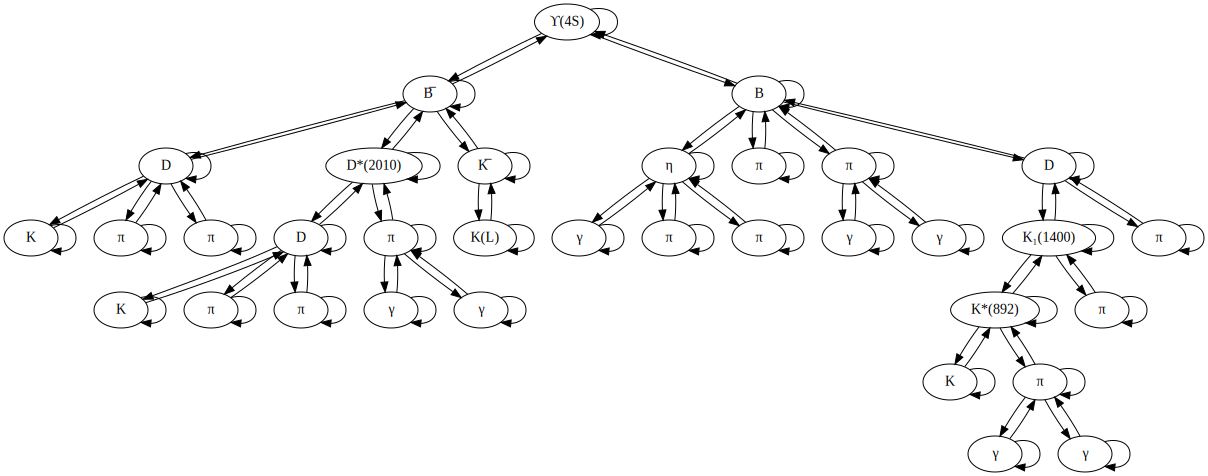

In [111]:
event_index = 0 # change to look at different events
draw_graph_from_adjacency(data["adj"][event_index], df.loc[event_index].pdg)

When iterating over the training dataset later to fit a model we also need to create batches of adjacency matrices.

Here we also need to pad the batches of adjacency matrices to the maximum event length:

In [112]:
def pad_adjacencies(adj_list):
    maxlen = max(len(adj) for adj in adj_list)
    batch = np.zeros((len(adj_list), maxlen, maxlen), dtype=bool)
    for i, adj in enumerate(adj_list):
        batch[i, :len(adj), :len(adj)] = adj
    return batch

So each batch will have features, pdg ids and adjacency matrices:

In [113]:
pad_sequences(data["pdg_mapped"][:256]).shape

(256, 67)

In [114]:
pad_sequences(data["features"][:256]).shape

(256, 67, 8)

In [115]:
pad_adjacencies(data["adj"][:256]).shape

(256, 67, 67)

Putting it together a `Dataset` and `collate_fn` for the `DataLoader` for this could look like the following

In [116]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, feat, pdg, adj, y):
        self.feat = feat
        self.pdg = pdg
        self.adj = adj
        self.y = y
        
    def __len__(self):
        return len(self.feat)
    
    def __getitem__(self, i):
        x = {
            "feat": self.feat[i],
            "pdg": self.pdg[i],
            "adj": self.adj[i]
        }
        y = self.y[i]
        return x, y

In [117]:
def collate_fn_graphs(inputs):
    feat, pdg, adj = [
        [x[key] for x, y in inputs] for key in ["feat", "pdg", "adj"]
    ]
    y = [y for x, y in inputs]
    x = {
        "feat": torch.tensor(pad_sequences(feat)),
        "pdg": torch.tensor(pad_sequences(pdg)),
        "adj": torch.tensor(pad_adjacencies(adj)),
    }
    y = torch.tensor(y)
    mask = (x["feat"] == 0).all(axis=-1)
    return x, y, mask

In [118]:
dl = DataLoader(
    GraphDataset(feat=data["features"], pdg=data["pdg_mapped"], adj=data["adj"], y=labels),
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn_graphs,
)

In [119]:
from tqdm.auto import tqdm

/home/p/Paul.Hofmann/pp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [120]:
for batch in tqdm(dl):
    pass

100%|██████████| 391/391 [00:01<00:00, 304.57it/s]


In [121]:
x, y, mask = batch

In [122]:
x["feat"].shape

torch.Size([160, 67, 8])

In [123]:
x["pdg"].shape

torch.Size([160, 67])

In [124]:
x["adj"].shape

torch.Size([160, 67, 67])

In [125]:
y.shape

torch.Size([160])

In [126]:
mask.shape

torch.Size([160, 67])

For using `GCN` layers in a model one needs the adjacency matrices as an additional input and feed them through `normalize_adjaceny` once before passing them over to a `GCN` layer. Here an example for a torch model that only applies a single `GCN` layer:

In [127]:
class GraphNetwork(nn.Module):
    def __init__(self, in_features, units=32):
        super().__init__()
        self.gcn = GCN(in_features, units)

    def forward(self, inputs, mask=None):
        adj = inputs["adj"]
        feat = inputs["feat"]
        adj = normalize_adjacency(adj)
        return self.gcn(feat, adj)

In [128]:
graph_network = GraphNetwork(len(feature_columns))

In [129]:
out = graph_network(x)
out.shape

torch.Size([160, 67, 32])